# **Model Training**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
print(f"{'torch:':<20} {torch.__version__}")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{'device:':<20} {device}")

import numpy as np
import math
import random
print(f"{'numpy:':<20} {np.__version__}")

import matplotlib.pyplot as plt
print(f"{'matplotlib:':<20} {plt.matplotlib.__version__}")

from tqdm import tqdm

import logger
print(f"{'logger (custom):':<20} loaded")

from Models.Architectures.edgeGNN import EdgeCentricNetwork
from DataManagement.data import financialDataset

torch:               2.7.1+cu118
device:              cuda
numpy:               2.2.4
matplotlib:          3.10.3
logger (custom):     loaded


c:\Users\lordw\OneDrive\Documents\ML\MLprojects\AlphaGrid\DataManagement\data_load.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sector_data = yf.download(tickers=list(sector_mapping.keys()), start=start_date, end=end_date)
[*********************100%***********************]  11 of 11 completed


Downloaded yfinance sector data for =:
-> Keys: ['XLK', 'XLF', 'XLE', 'XLV', 'XLI', 'XLP', 'XLY', 'XLU', 'XLB', 'XLRE', 'XLC']
-> Values: listdict_values(['Technology', 'Financials', 'Energy', 'Health Care', 'Industrials', 'Consumer Staples', 'Consumer Discretionary', 'Utilities', 'Materials', 'Real Estate', 'Communication Services'])
Flattening Column Labels to Remove Tuple-Based Column Structure... & Shifting Date into Column
* Done Preprocessing and Organizing Data *

=== Checking Download Uniformity ===
XLK: 1254 rows with data
XLF: 1254 rows with data
XLE: 1254 rows with data
XLV: 1254 rows with data
XLI: 1254 rows with data
XLP: 1254 rows with data
XLY: 1254 rows with data
XLU: 1254 rows with data
XLB: 1254 rows with data
XLRE: 1254 rows with data
XLC: 1254 rows with data
✓ All sectors have same number of dates
Common dates: 1254
XLK len: 1254
XLF len: 1254
XLE len: 1254
XLV len: 1254
XLI len: 1254
XLP len: 1254
XLY len: 1254
XLU len: 1254
XLB len: 1254
XLRE len: 1254
XLC len: 12

c:\Users\lordw\OneDrive\Documents\ML\MLprojects\AlphaGrid\DataManagement\data.py:74: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  feature_data = torch.tensor(data=feature_data, dtype=torch.float32).transpose(0, 1)


In [2]:
dataset = financialDataset()

c:\Users\lordw\OneDrive\Documents\ML\MLprojects\AlphaGrid\DataManagement\data_load.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sector_data = yf.download(tickers=list(sector_mapping.keys()), start=start_date, end=end_date)
[*************         27%                       ]  3 of 11 completed

[*********************100%***********************]  11 of 11 completed


Downloaded yfinance sector data for =:
-> Keys: ['XLK', 'XLF', 'XLE', 'XLV', 'XLI', 'XLP', 'XLY', 'XLU', 'XLB', 'XLRE', 'XLC']
-> Values: listdict_values(['Technology', 'Financials', 'Energy', 'Health Care', 'Industrials', 'Consumer Staples', 'Consumer Discretionary', 'Utilities', 'Materials', 'Real Estate', 'Communication Services'])
Flattening Column Labels to Remove Tuple-Based Column Structure... & Shifting Date into Column
* Done Preprocessing and Organizing Data *

=== Checking Download Uniformity ===
XLK: 1254 rows with data
XLF: 1254 rows with data
XLE: 1254 rows with data
XLV: 1254 rows with data
XLI: 1254 rows with data
XLP: 1254 rows with data
XLY: 1254 rows with data
XLU: 1254 rows with data
XLB: 1254 rows with data
XLRE: 1254 rows with data
XLC: 1254 rows with data
✓ All sectors have same number of dates
Common dates: 1254
XLK len: 1254
XLF len: 1254
XLE len: 1254
XLV len: 1254
XLI len: 1254
XLP len: 1254
XLY len: 1254
XLU len: 1254
XLB len: 1254
XLRE len: 1254
XLC len: 12

In [4]:
num_samples = len(dataset)

train_split = 0.8
test_split = 0.2

train_size = int(train_split * num_samples)
test_size = num_samples - train_size

train_dataset = torch.utils.data.Subset(dataset, list(range(train_size)))
test_dataset = torch.utils.data.Subset(dataset, list(range(train_size, num_samples)))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

sample_batch = next(iter(train_loader))
print(f"Batch Feature Dim: {sample_batch[0].shape}")
print(f"Batch Target Dim: {sample_batch[1].shape}")
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Test Dataset Length: {len(test_dataset)}")

Batch Feature Dim: torch.Size([32, 11, 89])
Batch Target Dim: torch.Size([32, 11])
Train Dataset Length: 978
Test Dataset Length: 245


In [3]:
model = EdgeCentricNetwork(num_nodes=dataset.num_sectors, directed=True, edge_dim=10, node_dim=dataset.features.shape[2])
model.to(device)
model

EdgeCentricNetwork(
  (edge_updater): Sequential(
    (0): Linear(in_features=178, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
  (regression): Sequential(
    (0): Linear(in_features=110, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Tanh()
  )
)

In [6]:
LR = 1e-3
optimizer = optim.Adam(params=model.parameters(), lr=LR)
criterion = nn.MSELoss()

epoch_num = 100

In [7]:
epoch_losses = []
batch_losses = []

model.train()
for epoch in range(epoch_num):
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epoch_num}]", leave=False)

    for features, targets in train_loader:
        features = features.to(device)
        targets = targets.unsqueeze(2).to(device)
        #print(torch.isnan(features).any())
        #print(torch.isinf(features).any())
        optimizer.zero_grad()

        output = model(features)

        loss = criterion(output, targets)
        
        loss.backward()
        optimizer.step()

        batch_losses.append(loss)
        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    epoch_losses.append(epoch_loss / len(train_loader))
    print(f"Epoch [{epoch+1}/{epoch_num}] Loss: {epoch_losses[-1]:.6f}")

Epoch [1/100] Loss: 1.123198


Epoch [2/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [2/100] Loss: 1.123198


Epoch [3/100] Loss: 1.123198


Epoch [4/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [4/100] Loss: 1.123198


Epoch [5/100] Loss: 1.123198


Epoch [6/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [6/100] Loss: 1.123198


Epoch [7/100] Loss: 1.123198


Epoch [8/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [8/100] Loss: 1.123198


Epoch [9/100] Loss: 1.123198


Epoch [10/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [10/100] Loss: 1.123198


Epoch [11/100] Loss: 1.123198


Epoch [12/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [12/100] Loss: 1.123198


Epoch [13/100] Loss: 1.123198


Epoch [14/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [14/100] Loss: 1.123198


Epoch [15/100] Loss: 1.123198


Epoch [16/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [16/100] Loss: 1.123198


Epoch [17/100] Loss: 1.123198


Epoch [18/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [18/100] Loss: 1.123198


Epoch [19/100] Loss: 1.123198


Epoch [20/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [20/100] Loss: 1.123198


Epoch [21/100] Loss: 1.123198


Epoch [22/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [22/100] Loss: 1.123198


Epoch [23/100] Loss: 1.123198


Epoch [24/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [24/100] Loss: 1.123198


Epoch [25/100] Loss: 1.123198


Epoch [26/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [26/100] Loss: 1.123198


Epoch [27/100] Loss: 1.123198


Epoch [28/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [28/100] Loss: 1.123198


Epoch [29/100] Loss: 1.123198


Epoch [30/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [30/100] Loss: 1.123198


Epoch [31/100] Loss: 1.123198


Epoch [32/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [32/100] Loss: 1.123198


Epoch [33/100] Loss: 1.123198


Epoch [34/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [34/100] Loss: 1.123198


Epoch [35/100] Loss: 1.123198


Epoch [36/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [36/100] Loss: 1.123198


Epoch [37/100] Loss: 1.123198


Epoch [38/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [38/100] Loss: 1.123198


Epoch [39/100] Loss: 1.123198


Epoch [40/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [40/100] Loss: 1.123198


Epoch [41/100] Loss: 1.123198


Epoch [42/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [42/100] Loss: 1.123198


Epoch [43/100] Loss: 1.123198


Epoch [44/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [44/100] Loss: 1.123198


Epoch [45/100] Loss: 1.123198


Epoch [46/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [46/100] Loss: 1.123198


Epoch [47/100] Loss: 1.123198


Epoch [48/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [48/100] Loss: 1.123198


Epoch [49/100] Loss: 1.123198


Epoch [50/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [50/100] Loss: 1.123198


Epoch [51/100] Loss: 1.123198


Epoch [52/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [52/100] Loss: 1.123198


Epoch [53/100] Loss: 1.123198


Epoch [54/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [54/100] Loss: 1.123198


Epoch [55/100] Loss: 1.123198


Epoch [56/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [56/100] Loss: 1.123198


Epoch [57/100] Loss: 1.123198


Epoch [58/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [58/100] Loss: 1.123198


Epoch [59/100] Loss: 1.123198


Epoch [60/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [60/100] Loss: 1.123198


Epoch [61/100] Loss: 1.123198


Epoch [62/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [62/100] Loss: 1.123198


Epoch [63/100] Loss: 1.123198


Epoch [64/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [64/100] Loss: 1.123198


Epoch [65/100] Loss: 1.123198


Epoch [66/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [66/100] Loss: 1.123198


Epoch [67/100] Loss: 1.123198


Epoch [68/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [68/100] Loss: 1.123198


Epoch [69/100] Loss: 1.123198


Epoch [70/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [70/100] Loss: 1.123198


Epoch [71/100] Loss: 1.123198


Epoch [72/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [72/100] Loss: 1.123198


Epoch [73/100] Loss: 1.123198


Epoch [74/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [74/100] Loss: 1.123198


Epoch [75/100] Loss: 1.123198


Epoch [76/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [76/100] Loss: 1.123198


Epoch [77/100] Loss: 1.123198


Epoch [78/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [78/100] Loss: 1.123198


Epoch [79/100] Loss: 1.123198


Epoch [80/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [80/100] Loss: 1.123198


Epoch [81/100] Loss: 1.123198


Epoch [82/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [82/100] Loss: 1.123198


Epoch [83/100] Loss: 1.123198


Epoch [84/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [84/100] Loss: 1.123198


Epoch [85/100] Loss: 1.123198


Epoch [86/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [86/100] Loss: 1.123198


Epoch [87/100] Loss: 1.123198


Epoch [88/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [88/100] Loss: 1.123198


Epoch [89/100] Loss: 1.123198


Epoch [90/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [90/100] Loss: 1.123198


Epoch [91/100] Loss: 1.123198


Epoch [92/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [92/100] Loss: 1.123198


Epoch [93/100] Loss: 1.123198


Epoch [94/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [94/100] Loss: 1.123198


Epoch [95/100] Loss: 1.123198


Epoch [96/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [96/100] Loss: 1.123198


Epoch [97/100] Loss: 1.123198


Epoch [98/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [98/100] Loss: 1.123198


Epoch [99/100] Loss: 1.123198


Epoch [100/100]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.11]

Epoch [100/100] Loss: 1.123198


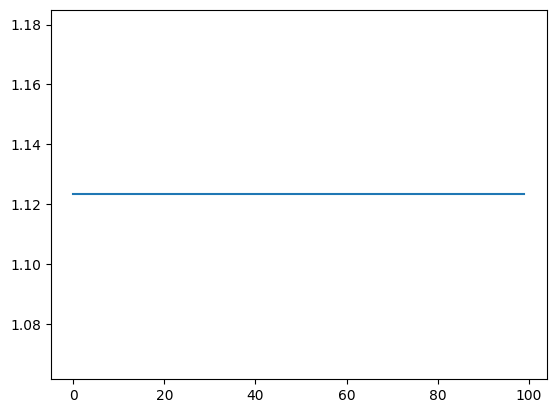

In [8]:
plt.plot(epoch_losses)